In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd

#Load hospital data
merged_data = pd.read_pickle("/content/drive/My Drive/תחלואה/notebooks/merged_data_7May2020.pkl")

In [3]:
print(merged_data['hospital'].unique())

['AssafHarofe' 'BneiZion' 'Barzilai' 'HilelYaffe' 'Galil' 'Volfson' 'Ziv'
 'Poriya' 'Rambam' 'Shiba']


In [0]:
#Run a smoothing filter on the hospitalization data
from scipy import signal
b, a = signal.butter(14, 0.07)

if (1):
  smoothed_merged_data = merged_data

  for column in smoothed_merged_data:
    if (column != "Date") and (column != "hospital"):
      smoothed_merged_data[column] = signal.filtfilt(b, a, smoothed_merged_data[column], padlen=7)
      #smoothed_merged_data[column] = smoothed_merged_data[column].rolling(window=14).mean()

  merged_data = smoothed_merged_data

In [5]:
air_quality = pd.read_excel("/content/drive/My Drive/תחלואה/אקלים וזיהום/FormattedStationData.xlsx")

air_quality["DateTime"] = pd.to_datetime(air_quality["Date-Time"],errors='coerce')
air_quality["PollutionDate"] = air_quality["DateTime"].dt.date

#Check if all dates have been processed (should be zero)
print(len(air_quality["DateTime"]) - air_quality["DateTime"].count())

#print(air_quality)

0


In [0]:
#Keep only columns with pollutants
if (0):
  filtered_air_quality = air_quality.loc[:, air_quality.columns.str.contains(r'\b(PollutionDate|O3|NO2|NO|NOX|SO2|TOC_SCRUBBER|TOC_RTO|PM10|CO|PM2\.5|BENZN|O\-Xyle|TOLUEN|EthylB|M+P\-XY|1\-3butadiene|TOL|pm\(10\-2.5\)|NOx|PM1|BLACK CARBON|H2S|CO TRAFIC|NO2 TRAFIC|NO TRAFIC|NOX TRAFIC)\b')] 
else:
  filtered_air_quality = air_quality

In [0]:
#Run a smoothing filter on the air quality data
from scipy import signal
b, a = signal.butter(14, 0.07)

if (0):
  smoothed_filtered_air_quality = filtered_air_quality
  smoothed_filtered_air_quality = smoothed_filtered_air_quality.fillna(-1)

  for column in smoothed_filtered_air_quality:
    if (column != "PollutionDate") and (column != "Date-Time") and (column != "DateTime"): 
      smoothed_filtered_air_quality[column] = signal.filtfilt(b, a, smoothed_filtered_air_quality[column], padlen=14)
      #smoothed_filtered_air_quality[column] = smoothed_filtered_air_quality[column].rolling(window=14).mean()

  filtered_air_quality = smoothed_filtered_air_quality

In [9]:
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from scipy.stats.stats import pearsonr   

#lag = 0
hospital = 'Rambam'

weather_cols = [col for col in filtered_air_quality.columns if 'Date' not in col]

correlations = pd.DataFrame(columns=['Lag', 'Cor'])

for lag in range(-60, 60):
  filtered_air_quality["ShiftedPollutionDate"] = pd.DatetimeIndex(filtered_air_quality["PollutionDate"]) + pd.DateOffset(lag);
  merged_all = pd.merge(merged_data, filtered_air_quality, how='left', left_on='Date', right_on='ShiftedPollutionDate')
  merged_all = merged_all.fillna(-1)

  #Split to train and test
  train_row_mask = (merged_all["hospital"] == hospital) & (merged_all['Date'] <= '2018-12-31')
  test_row_mask  = (merged_all["hospital"] == hospital) & (merged_all['Date'] > '2018-12-31')

  X_train = merged_all.loc[train_row_mask, weather_cols]
  y_train = merged_all.loc[train_row_mask, "all_visits"]
  X_test  = merged_all.loc[test_row_mask, weather_cols]
  y_test  = merged_all.loc[test_row_mask, "all_visits"]

  #rf = RandomForestRegressor(n_estimators = 10)
  #rf.fit(X_train, y_train);
  #pred = rf.predict(X_test)

  model = sm.OLS(y_train.astype(float), X_train.astype(float)).fit()
  pred  = model.predict(X_test.astype(float))

  #curCorr = y_test.corr(pred)
  curCorr = pearsonr(pred, y_test)
  curCorr = curCorr[0]

  correlations = correlations.append({'Lag': lag, 'Cor': curCorr}, ignore_index=True)
  print(".", end='')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


........................................................................................................................

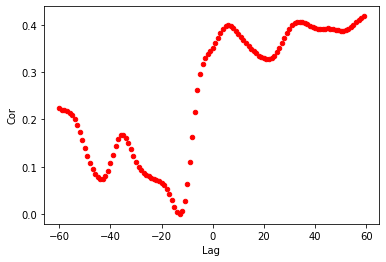

In [10]:
from scipy import signal
b, a = signal.butter(5, 0.2)

correlations2 = correlations
y = signal.filtfilt(b, a, correlations2['Cor'], padlen=5)
correlations2['Cor'] = y
#print(correlations2['Cor'])

correlations2.plot(kind='scatter',x='Lag',y='Cor',color='red')

In [0]:
#Read inversion data
inversion = pd.read_csv("/content/drive/My Drive/תחלואה/אקלים וזיהום/inversion_index.csv")
inversion["date"] = pd.to_datetime(inversion["date"],errors='coerce')


In [12]:
import statsmodels.api as sm
import numpy as np

#lag = 0
hospital = 'Rambam'

cols = [col for col in inversion.columns if 'date' not in col]

correlations = pd.DataFrame(columns=['Lag', 'Cor'])

for lag in range(-60, 60):
  inversion["ShiftedPollutionDate"] = pd.DatetimeIndex(inversion["date"]) + pd.DateOffset(lag)

  merged_all = pd.merge(merged_data, inversion, how='left', left_on='Date', right_on='ShiftedPollutionDate')
  merged_all = merged_all.fillna(-1)

  #Split to train and test
  train_row_mask = (merged_all["hospital"] == hospital) & (merged_all['Date'] <= '2018-12-31')
  test_row_mask  = (merged_all["hospital"] == hospital) & (merged_all['Date'] > '2018-12-31')

  X_train = merged_all.loc[train_row_mask, cols]
  y_train = merged_all.loc[train_row_mask, "all_visits"]
  X_test  = merged_all.loc[test_row_mask, cols]
  y_test  = merged_all.loc[test_row_mask, "all_visits"]

  model = sm.OLS(y_train.astype(float), X_train.astype(float)).fit()
  pred  = model.predict(X_test.astype(float))

  correlations = correlations.append({'Lag': lag, 'Cor': y_test.corr(pred)}, ignore_index=True)
  print(".", end='')

........................................................................................................................

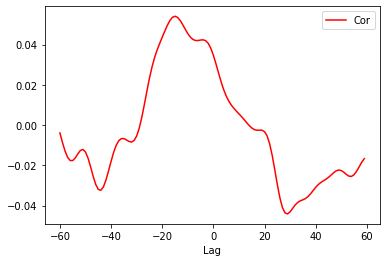

In [13]:
from scipy import signal
b, a = signal.butter(5, 0.2)

correlations2 = correlations
y = signal.filtfilt(b, a, correlations2['Cor'], padlen=5)
correlations2['Cor'] = y
#print(correlations2['Cor'])

#correlations2['Cor'] = correlations2['Cor'].filtfilt(window=5).mean()

correlations2.plot(kind='line',x='Lag',y='Cor',color='red')

In [14]:
print(merged_data.columns)

Index(['hospital', 'Date', 'keep', 'hospitalization_0-1',
       'hospitalization_1-4', 'hospitalization_5-18', 'hospitalization_19-34',
       'hospitalization_35-64', 'hospitalization_65-74',
       'hospitalization_75-84', 'hospitalization_85plus',
       'all_hospitalizations', 'release_0-1', 'release_1-4', 'release_5-18',
       'release_19-34', 'release_35-64', 'release_65-74', 'release_75-84',
       'release_85plus', 'all_releases', 'all_visits'],
      dtype='object')
